In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.api import OLS,Logit
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
import matplotlib.gridspec as gs
import seaborn as sns
import argparse
from scipy.stats import zscore,pearsonr,spearmanr,gaussian_kde
from scipy.special import logit,expit
from scipy.spatial.distance import euclidean
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from PRS import PRS # custom script to run PRS with DeGAs input data

In [2]:
### 1. load data
proj_dir="" # redacted
ukb_root=""
dataset=proj_dir'datasets/train/v2/tsvd/all_beta_center_p1e-06_20200506_500PCs.npz'
npc=300
phe_codes=['HC221']
covariates=['age','sex']+['PC'+str(i+1) for i in range(4)]+['1']
score_pcs=['SCORE{}_SUM'.format(pc+1) for pc in range(npc)]
profl_pcs=['PROF_PC{}'.format(pc+1) for pc in range(npc)]
z=np.load(dataset, allow_pickle=True)
scores=pd.read_table(proj_dir+'scorefiles/v2/'+os.path.splitext(os.path.basename(dataset))[0]+'.sscore',
                     index_col='#IID')
phenos=pd.read_table(proj_dir+'master.20200420.phe',
                     usecols=['IID']+phe_codes+covariates[:-1],
                     index_col='IID',
                     na_values=-9)
phenos['1']=1
with open('../reference/stashed/Degas-Risk-Phenotypes.tsv','r') as f:
    code_to_name = {line.split()[0]:line.split()[2].replace('_',' ').capitalize() for line in f}

In [3]:
# 2. define population groupings
train=set(pd.read_table(proj_dir+'population-split/'+
                         'ukb24983_white_british_train.phe').iloc[:,0].astype(float).dropna().tolist())
valid=set(pd.read_table(proj_dir+'population-split/'+
                         'ukb24983_white_british_valid.phe').iloc[:,0].astype(float).dropna().tolist())
test=set(pd.read_table(proj_dir+'population-split/'+
                         'ukb24983_white_british_test.phe').iloc[:,0].astype(float).dropna().tolist())
nbw=set(pd.read_table(ukb_root+'sqc/population_stratification/'+
                         'ukb24983_non_british_white.phe').iloc[:,0].astype(float).dropna().tolist())
print(list(map(len,[train,valid,test,nbw])))

[236004, 33715, 67429, 24904]


In [4]:
# 3. analysis
for phe_code in phe_codes:
    # run PRS for this trait if not already done
    prs_f=os.path.join(proj_dir+'PRS/train/v2/',
                       os.path.splitext(os.path.basename(dataset))[0][:-7], 
                       phe_code+'_PRS.profile')
    if not os.path.exists(prs_f):
        PRS(dataset.replace('tsvd/','').replace('_500PCs.npz','.full_df.pkl.gz'), phe_code)
    prs=pd.read_table(prs_f, sep='\s+', usecols=['IID','SCORESUM'], index_col='IID').rename(columns={'SCORESUM':'PRS'})
    # name phenotype, set up datasets
    phe_name=code_to_name[phe_code]
    df=phenos.loc[train | valid | test | nbw, [phe_code]+covariates].dropna()
    df=df.merge(scores, left_index=True, right_index=True).merge(prs, left_index=True, right_index=True)
    weights=z['V'][np.where(z['label_phe_code'] == phe_code),:].flatten()[:npc]
    df['dPRS']=df[score_pcs].dot(weights)
    # is trait binary or quantitative?
    is_bin=(len(df[phe_code].value_counts()) == 2)
    if is_bin: 
        df[phe_code]-=1
        regress=Logit
    else:
        regress=OLS
    # setup for regression models
    models={prs:{m:{} for m in ['RAW','COVAR','RESID','JOINT']} for prs in ['PRS','dPRS']}
    params={prs:{'RAW':[prs], 'COVAR':covariates, 'JOINT':covariates+[prs]} for prs in ['PRS','dPRS']}
    stats ={prs:pd.DataFrame(index=['train','valid','test','nbw'], 
                             columns=['n','beta2','auc','pearsonr','spearmanr']) for prs in ['PRS','dPRS']}
    # iterate through populations, fit/predict/compute stats
    for prs in ['PRS','dPRS']:
        for pop_id,pop in zip(['train','valid','test','nbw'],[train,valid,test,nbw]):
            # take a new subset
            pop=np.array([ind for ind in pop if ind in df.index])
            df2=df.loc[np.array(pop),:].dropna()
            # zscore (d)PRS within the phenotype group; trait too if quantitative
            df2[prs]=zscore(df2[prs])
            if not is_bin:
                df2[phe_code]=zscore(df2[phe_code])
            # loop over models: dPRS alone, covars alone, dPRS ~ resid(phe ~ covars), joint model
            for m in ['RAW','COVAR','RESID','JOINT']:
                # use covariate model fit within population, regress on residuals
                if m=='RESID':
                    models[prs][m][pop_id]=OLS(models[prs]['COVAR'][pop_id].resid_pearson, 
                                               df2.loc[pop,prs]).fit(disp=0)
                # use joint model fit in validation for test and nbw; fit in train for test
                elif m=='JOINT' and pop_id in ['test','nbw']:
                    models[prs][m][pop_id]=models[prs][m]['valid']
                elif m=='JOINT' and pop_id == 'valid':
                    models[prs][m][pop_id]=models[prs][m]['train']
                # otherwise just fit and assess within the same group
                else:
                    models[prs][m][pop_id]=regress(df2.loc[pop,phe_code], df2.loc[pop,params[prs][m]]).fit(disp=0)
            # compute these stats: # beta/OR of top 2% versus entire group; AUC of joint model (bin); 
            # r of resid model (qt); N; and spearman rho between dPRS and trait (bin & QT)
            # helper for beta2 and subplot (A) below:
            def prs_betaci(qq, prs, df):
                q0,q1=qq
                we_print=(q0==2)
                q0=df[prs].quantile((100-q0)/100.0),  # pandas has 99 as the highest; we have 1 as the highest
                q1=df[prs].quantile((100-q1)/100.0)
                q40=df[prs].quantile(0.4)
                q60=df[prs].quantile(0.6)   
                iids=df.index[((q0 <= df[prs]) & (df[prs] <= q1)) | ((q40 <= df[prs]) & (df[prs] <= q60))]
                if is_bin:
                    data=np.vstack((expit(models['PRS']['COVAR']['train'].predict(df.loc[iids,covariates])), 
                                    (q0 <= df.loc[iids,prs]) & (df.loc[iids,prs] <= q1))).T
                    m=Logit(df.loc[iids,phe_code], data).fit(disp=0)
                    b=np.exp(m.params[1])
                    ci=np.abs(np.exp(m.conf_int().iloc[1,:].values)-b)
                else:
                    data=np.vstack((models['PRS']['COVAR']['train'].predict(df.loc[iids,covariates]), 
                                    (q0 <= df.loc[iids,prs]) & (df.loc[iids,prs] <= q1))).T
                    m=OLS(df.loc[iids,phe_code], data).fit(disp=0)
                    b=m.params[1]
                    ci=np.abs(m.conf_int().iloc[1,:].values-b)
                if we_print:
                    print(b, ci)
                return b,ci,df.loc[(q0 <= df[prs]) & (df[prs] <= q1),phe_code].mean()
            if is_bin:
                stats[prs].loc[pop_id,'beta2']=prs_betaci((2,0), prs, df2.loc[pop,:])[0]
                stats[prs].loc[pop_id,'auc']=roc_auc_score(df2.loc[pop,phe_code], models[prs]['JOINT'][pop_id].predict(
                                                                                    df2.loc[pop,params[prs]['JOINT']]))
                stats[prs].loc[pop_id,'pearsonr']='na'
                stats[prs].loc[pop_id,'n']=df2.loc[pop,phe_code].value_counts().loc[1]
            else:
                stats[prs].loc[pop_id,'beta2']=prs_betaci((2,0), prs, df2.loc[pop,:])[0]
                stats[prs].loc[pop_id,'auc']='na'
                stats[prs].loc[pop_id,'pearsonr']=pearsonr(models[prs]['COVAR'][pop_id].resid, df2.loc[pop,prs])[0]
                stats[prs].loc[pop_id,'n']=df2.loc[pop,phe_code].shape[0]
            stats[prs].loc[pop_id,'spearmanr']=spearmanr(df2.loc[pop,phe_code],df2.loc[pop,prs])[0]
        print(prs)
        print(stats[prs])

1.6001033101991198 [0.15244107 0.16849335]
1.4816868879684428 [0.35394438 0.46503058]
1.4916179712246806 [0.26357054 0.32013956]
1.3988359611284227 [0.39259192 0.54576393]
PRS
           n    beta2       auc pearsonr  spearmanr
train  16269   1.6001  0.665923       na  0.0689253
valid   2315  1.48169  0.668029       na  0.0669358
test    4541  1.49162  0.661525       na  0.0576498
nbw     1571  1.39884  0.674025       na  0.0629583
1.5647845968147673 [0.15156259 0.16781709]
1.4451676378005418 [0.3469291 0.4565226]
1.2535153354458537 [0.23213763 0.28489762]
1.3570693286330369 [0.39456437 0.55631008]
dPRS
           n    beta2       auc pearsonr  spearmanr
train  16269  1.56478  0.650723       na  0.0154986
valid   2315  1.44517  0.653956       na  0.0159603
test    4541  1.25352  0.650689       na  0.0161947
nbw     1571  1.35707  0.661641       na  0.0284709


1.4916179712246806 [0.26357054 0.32013956]
1.2535153354458537 [0.23213763 0.28489762]


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 235 outliers!
PC6: 54.1%, PC11: 4.0%, PC19: 2.3%, PC18: 2.1%, PC16: 1.9%
PC9: 37.0%, PC28: 5.6%, PC11: 4.8%, PC44: 2.7%, PC20: 2.0%


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:189: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:195: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

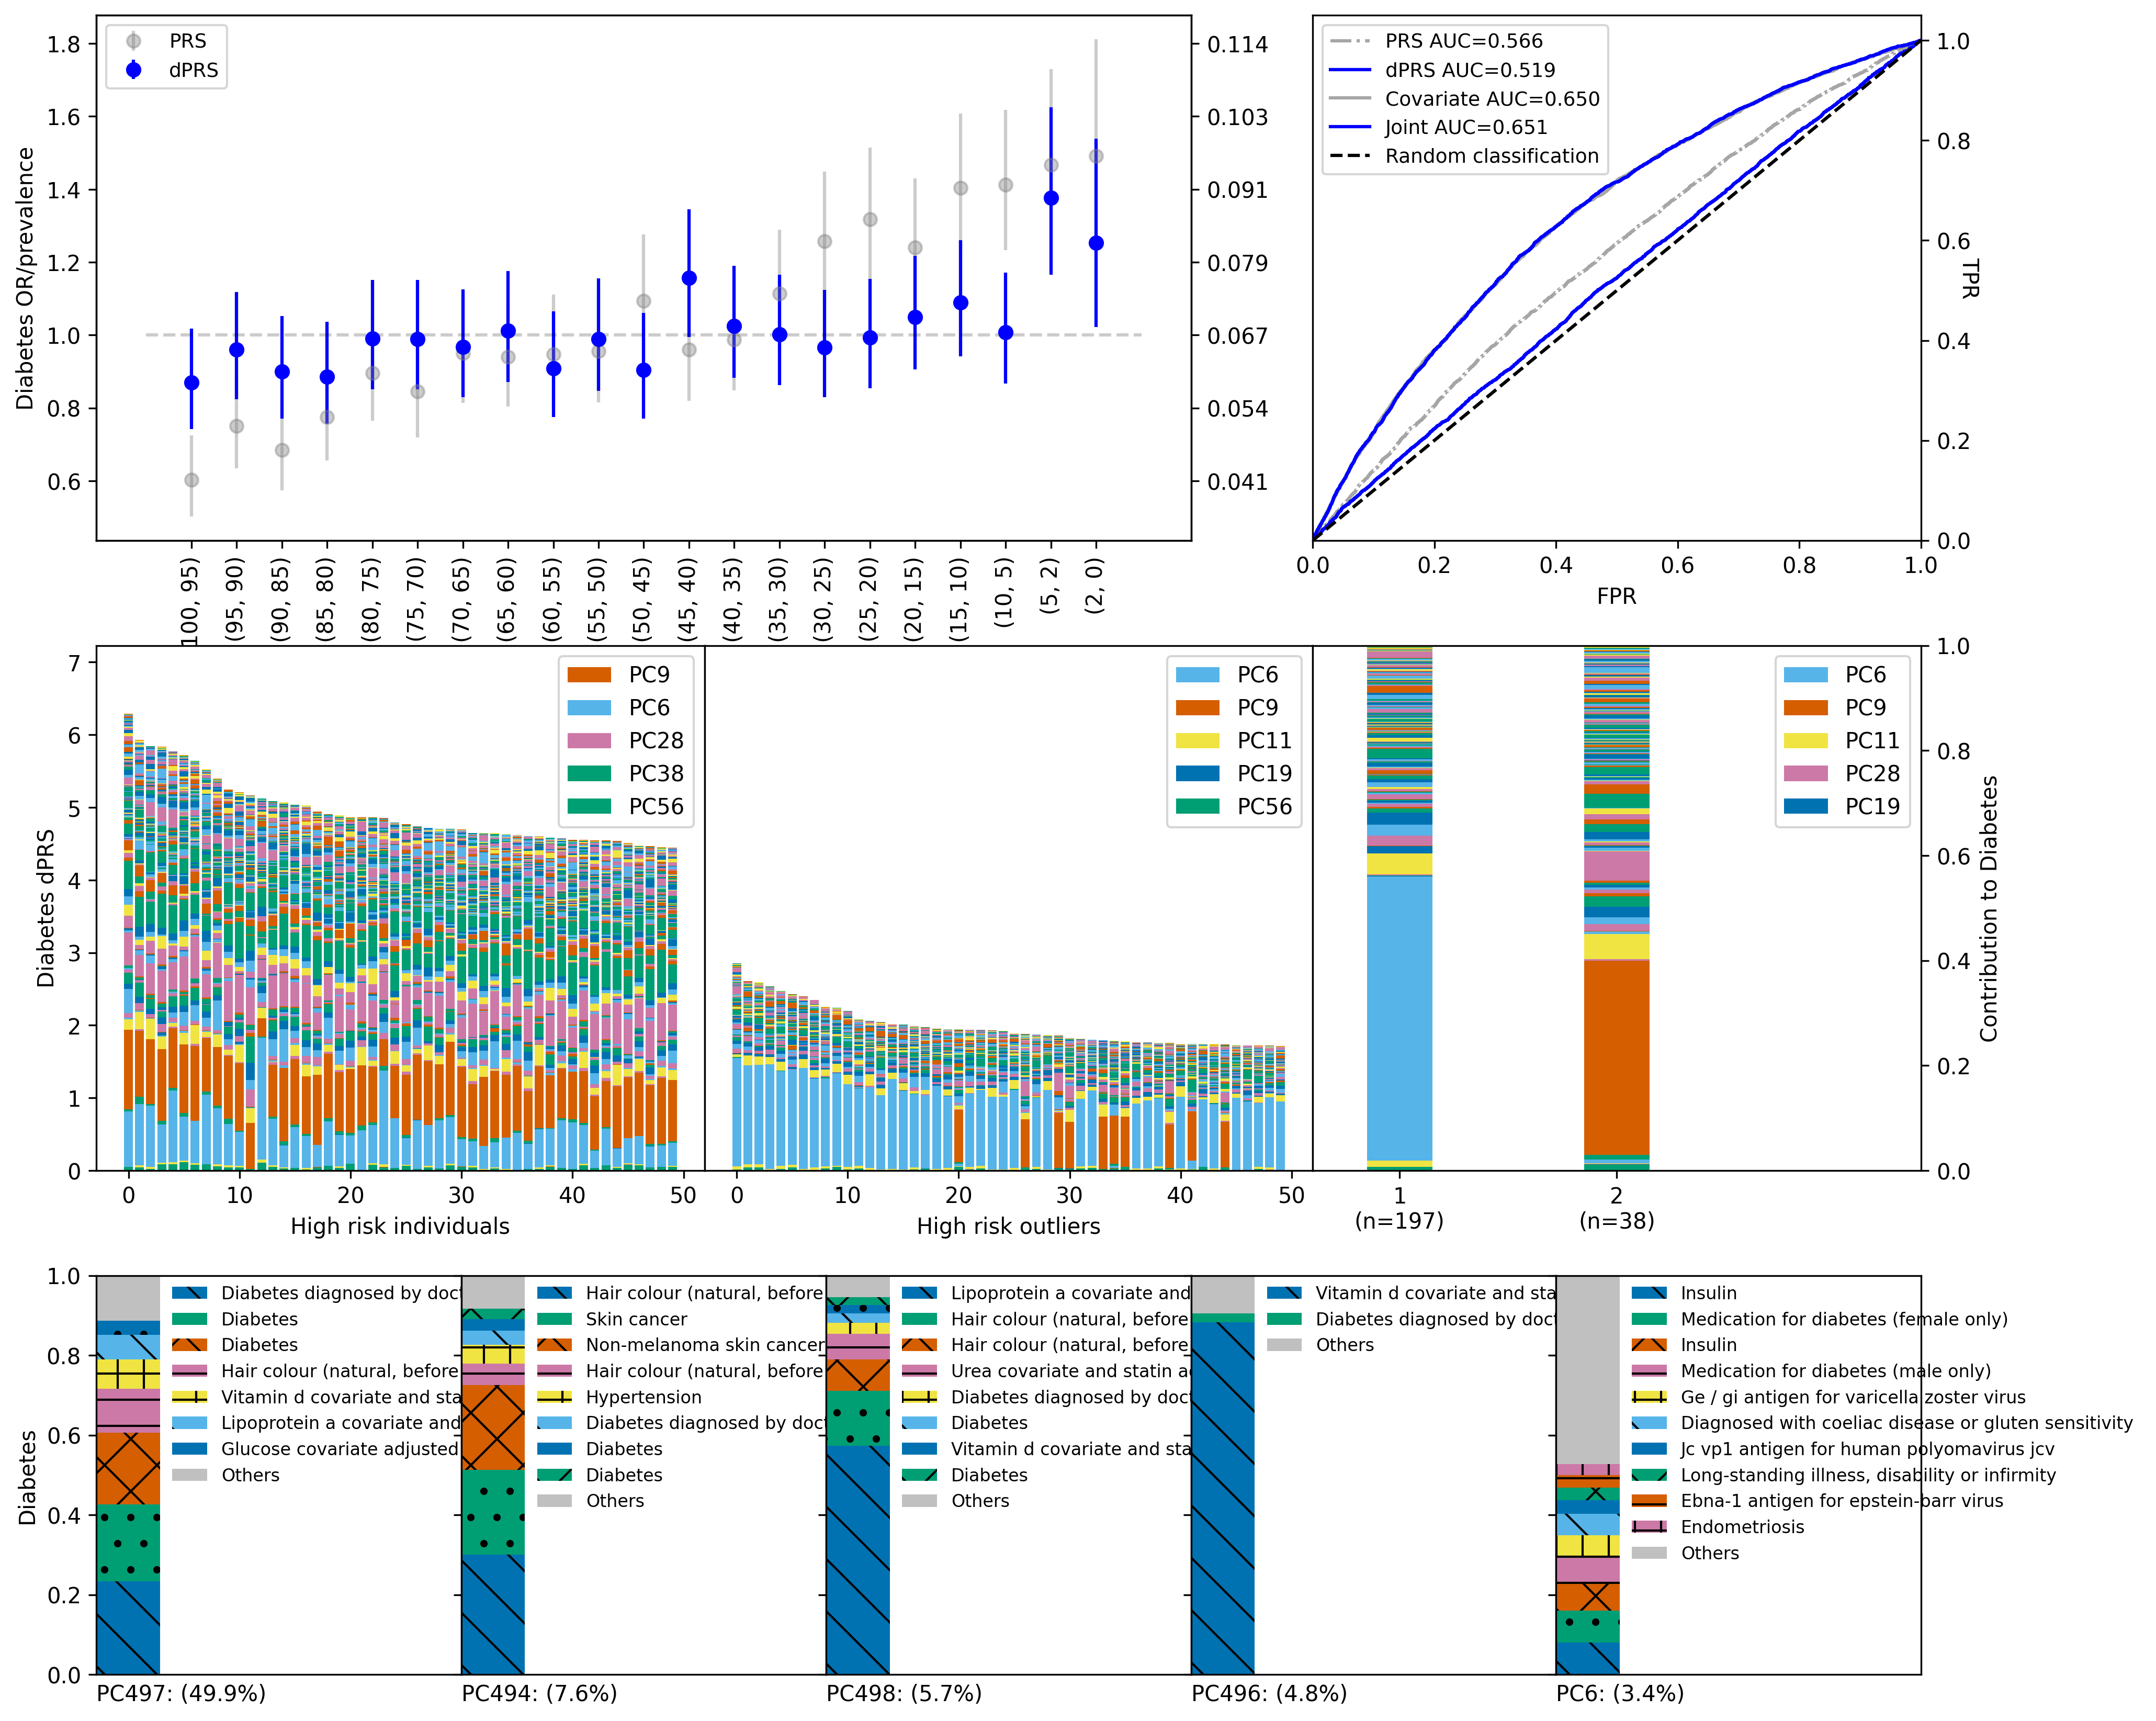

In [5]:
width = 2
# initialize plot objects
plots = [None for _ in range(10)]
plt.close('all'); plt.clf()
fig = plt.figure(figsize=(15, 14), dpi=300)
grid=gs.GridSpec(14, 15, wspace=0, hspace=5)
        
for pop_id,pop in zip(['test'], [test]):
    # setup plot
    plots[0]=plt.subplot(grid[:5,:9])
    plots[1]=plt.subplot(grid[:5,10:])
    plots[2]=plt.subplot(grid[5:10,:5])
    plots[3]=plt.subplot(grid[5:10,5:10])
    plots[4]=plt.subplot(grid[5:10,10:])
    plots[5]=plt.subplot(grid[10:,:3])
    plots[6]=plt.subplot(grid[10:,3:6])
    plots[7]=plt.subplot(grid[10:,6:9])
    plots[8]=plt.subplot(grid[10:,9:12])
    plots[9]=plt.subplot(grid[10:,12:])
    # take a new subset
    df2=df.loc[[i for i in pop if i in df.index],:].copy().dropna()
    for prs in ['PRS','dPRS']:
        df2[prs]=zscore(df2[prs])
    pop=df2.index.tolist()
    # (A) do quantile plot with modified (only if binary) phenotype
    qs=[(q+5,q) for q in np.arange(5,100,5)[::-1]] + [(5,2),(2,0)]
    for prs,name in zip(['PRS','dPRS'],['PRS','dPRS']):
        fits=[prs_betaci(q, prs, df2.loc[pop,:]) for q in qs]
        plots[0].errorbar(x=np.arange(len(qs)), y=[p[0] for p in fits], yerr=np.array([p[1] for p in fits]).T,
                            fmt='o', c='b' if name=='dPRS' else 'grey', alpha=0.4+0.6*(name=='dPRS'))
        if name=='dPRS' and is_bin:
            p2=df2.loc[(df2.loc[pop,prs].quantile(0.4) <= df2.loc[pop,prs]) & 
                       (df2.loc[pop,prs] <= df2.loc[pop,prs].quantile(0.6)), phe_code].mean()
            aax=plots[0].twinx()
            aax.set_yticks(plots[0].get_yticks())
            if is_bin:
                aax.set_yticklabels(['{:.3f}'.format(k*p2/(1-p2+(k*p2))) if k > 0 else '' 
                                                     for k in plots[0].get_yticks()])
            else:
                aax.set_yticklabels(['{:.1f}'.format(k+p2) for k in plots[0].get_yticks()])
            aax.set_ylim(plots[0].get_ylim())
    # labels    
    plots[0].set_xlabel('(d)PRS quantile')
    plots[0].set_xticklabels(list(map(str,qs)), rotation=90)
    plots[0].set_ylabel(phe_name+' {}'.format('OR/prevalence' if is_bin else 'beta/mean'))
    plots[0].set_xticks(np.arange(len(qs)))
    plots[0].legend(['PRS','dPRS'], loc=2, fontsize=9)
    plots[0].plot(plots[0].get_xlim(),[1 if is_bin else df2[phe_code].mean() for _ in range(2)],'k--',alpha=0.2)
    # (B) plot ROC/correlation plot
    if is_bin:
        # loop over dPRS and these joint models
        for w,(prs,mt) in enumerate(zip(['PRS','dPRS','dPRS','dPRS'],['RAW','RAW','COVAR','JOINT'])):
            # compute stats, plot them
            fpr,tpr,_=roc_curve(  df2.loc[pop,phe_code], 
                                  models[prs][mt][pop_id].predict(df2.loc[pop,params[prs][mt]]))
            roc_auc=roc_auc_score(df2.loc[pop,phe_code], 
                                  models[prs][mt][pop_id].predict(df2.loc[pop,params[prs][mt]]))
            plots[1].plot(fpr, tpr, 
                          label='{0} AUC={1:.3f}'.format(prs if mt=='RAW' else mt.capitalize().replace('r', 'riate'),
                                                         roc_auc), 
                          color='b' if w%2 else 'grey', alpha=0.7+0.3*(w%2), linestyle='-' if w/2 else '-.')
        # add null line, axis labels
        plots[1].plot([0, 1],[0, 1],'k--',label='Random classification')
        plots[1].legend(fontsize=9)
        plots[1].set_xlim([0.0, 1.0])
        plots[1].set_ylim([0.0, 1.05])
        plots[1].set_xlabel('FPR')
        plots[1].set_ylabel('TPR', rotation=270)
    else:
        # plot correlation with dPRS and standardized residual phenotype
        x,y={},{}
        for prs in ['PRS','dPRS']: # scoresum is PRS, score is dPRS -- confused yet? me too.
            x[prs],y[prs] = df2.loc[pop,prs], models[prs]['COVAR'][pop_id].resid_pearson
            sns.regplot(x=x[prs], y=y[prs], ax=plots[1], color='b' if prs == 'dPRS' else 'grey',
                        scatter_kws={'s':2, 'alpha':0.05+0.05*(prs!='PRS')})
        plots[1].set_ylabel(code_to_name[phe_code]+' Residual', rotation=270, labelpad=15)
        plots[1].legend([prs+' '+'$r=$'+'{:.3f}'.format(pearsonr(x[prs], y[prs])[0]) for prs in ['PRS','dPRS']])
        plots[1].set_xlabel('Standardized (d)PRS')
    plots[1].yaxis.tick_right()
    plots[1].yaxis.set_label_position("right")
    
    # (C): high risk individuals (first compute profiles)
    df2.sort_values(by='dPRS', inplace=True, ascending=True)
    for pc in range(npc):
        df2[profl_pcs[pc]]=(df2[score_pcs[pc]] * weights[pc] * df2[prs]).clip(lower=0)
    df2[profl_pcs] = normalize(df2[profl_pcs], norm='l1')
    # now plot
    o, pc_plots=50, []
    dfo=df2.iloc[-o:,:][::-1]
    top5pc=np.argsort(dfo[prs].dot(dfo[profl_pcs])[:npc])[-5:][::-1]
    for pc in range(npc):
        pp=plots[2].bar(np.arange(o), 
                        dfo[profl_pcs[pc]] * dfo[prs],
                        bottom=np.array(dfo[profl_pcs[:pc]].sum(axis=1) * dfo[prs])#,
                        # hatch=pcps[pc+1] if pc+1 in pcps else None
                        )
        pc_plots.append(pp)
    # axis labels and such
    plots[2].set_ylim(0, 1.15*df2[prs].max())
    plots[2].set_ylabel(phe_name+' dPRS')
    plots[2].set_xlabel('High risk individuals')
    plots[2].legend([pc_plots[pc] for pc in top5pc], ['PC'+str(pc+1) for pc in top5pc], loc=1)

    # (D): outliers (first find them)
    centroid=df2[profl_pcs].median()
    df3=df2.iloc[-int(0.1*len(pop)):]
    df3['mahal']=df3[profl_pcs].apply(lambda x: euclidean(x, centroid), axis=1)
    m_star=df3['mahal'].mean() + 1.96*df3['mahal'].std() # might need to tweak this to be more lenient, as done here
    outliers=df3.query('mahal > @m_star').index
    print("found {} outliers!".format(outliers.shape[0]))
    
    # now plot them
    dfo=df2.loc[outliers[-o:],:][::-1]
    top5pc=np.argsort(dfo[prs].dot(dfo[profl_pcs])[:npc])[-5:][::-1]
    pc_plots2=[]
    for pc in range(npc):
        pp=plots[3].bar(np.arange(o), 
                        dfo[profl_pcs[pc]] * dfo[prs],
                        bottom=np.array(dfo[profl_pcs[:pc]].sum(axis=1) * dfo[prs])#,
                        # hatch=pcps[pc+1] if pc+1 in pcps else None
                        )
        pc_plots2.append(pp)
    # axis labels and such
    plots[3].set_ylim(0, 1.15*df2[prs].max())
    plots[3].set_ylabel(''); plots[3].set_yticks([])
    plots[3].set_xlabel('High risk outliers')
    plots[3].legend([pc_plots[pc] for pc in top5pc], ['PC'+str(i+1) for i in top5pc], loc=1)    
    
    # (E): Cluster centers (first compute them)
    k=1
    cluster = KMeans(n_clusters=k, n_init=25).fit(df3.loc[outliers,profl_pcs])
    pre_frac = 0.8 - 10.0/len(outliers)
    errors = [cluster.inertia_]
    for new_k in [2,3,4,5]:
        new_cluster = KMeans(n_clusters=new_k, n_init=25).fit(df3.loc[outliers,profl_pcs])
        errors.append(new_cluster.inertia_)
        if new_cluster.inertia_ / cluster.inertia_ < pre_frac**(new_k - k): 
            cluster,k = new_cluster,new_k
    
    # now plot them
    ms = cluster.cluster_centers_[0:k]
    x,p = np.arange(k), []
    top5pcs = np.argsort(np.sum(ms, axis=0))[-5:]
    for pc in range(ms.shape[1]):
        zz=plots[4].bar(x, ms[:,pc], bottom=np.sum(ms[:,0:pc], axis=1), width=0.3)#,
                                     #hatch=pcps[pc+1] if pc+1 in pcps else None)
        p.append(zz)
    # print out cluster centroids
    for j in range(ms.shape[0]):
        print(', '.join([': '.join(('PC'+str(pc+1),'{:.1f}%'.format(100*f))) for pc,f in sorted(enumerate(ms[j,:]), 
                                                                                       key=lambda x:-x[1])[:5]]))
    # axis label
    plots[4].set_xlabel('')
    plots[4].set_ylabel('Contribution to '+phe_name)
    plots[4].set_ylim((0, 1))
    plots[4].set_xlim((-0.4,k+0.4))
    plots[4].set_xticks(np.arange(k))
    plots[4].set_xticklabels([str(x+1)+'\n(n='+str(y)+')' 
                                for x,y in enumerate(list(pd.Series(cluster.labels_).value_counts()))])
    plots[4].legend([p[i] for i in reversed(top5pcs)], ['PC' + str(i+1) for i in reversed(top5pcs)])
    plots[4].yaxis.tick_right()
    plots[4].yaxis.set_label_position("right")
    
    # (F-J): Components
    V = z['V'] * z['D']
    pix=np.where(z['label_phe_code']==phe_code)
    patterns = ('.', 'x', '-', '+', '\\')
    for pcx in range(5):
        # setup: figure, which component, traits therein
        pc=np.argsort(V[pix,:]**2).flatten()[-(pcx+1)]
        ranked_phes=np.argsort(V[:,pc]**2)[::-1].flatten()
        # loop over top 10 traits, plot bars if bar above 1%
        for ix,phe_ix in enumerate(ranked_phes[:10]):
            if (z['V'][phe_ix,pc]**2)/np.sum(z['V'][:,pc]**2) > 0.02:
                plots[5+pcx].bar([0], [(z['V'][phe_ix,pc]**2)/np.sum(z['V'][:,pc]**2)], 
                                 bottom=np.sum(z['V'][ranked_phes[:ix],pc]**2),
                                 label=code_to_name[z['label_phe_code'][phe_ix]],
                                 hatch=patterns[(ix + 4) % len(patterns) ]
                                )
            else: ix-=1; break
        ix+=1
        # add grey bar on top
        plots[5+pcx].bar([0], [1-(np.sum(z['V'][ranked_phes[:ix],pc]**2)/np.sum(z['V'][:,pc]**2))],
                         bottom=np.sum(z['V'][ranked_phes[:ix],pc]**2)/np.sum(z['V'][:,pc]**2), 
                         color='silver', label='Others')
        # adjust figure ticks/limits; add labels
        plots[5+pcx].set_ylim(0,1); 
        plots[5+pcx].set_xlim(0,2.3)
        plots[5+pcx].set_xticks([],[])
        plots[5+pcx].set_xlabel('PC{0}: ({1:.1f}%)'.format(pc+1, 100*((V[pix,pc]**2)/np.sum(V[pix,:]**2))[0][0]), 
                                 horizontalalignment='left', x=0.0)
        if pcx==0:
            plots[5].set_ylabel(code_to_name[phe_code])
        else:
            plots[5+pcx].set_yticklabels(['' for _ in plots[5+pcx].get_yticks()])
        lgd=plots[5+pcx].legend(loc='upper left', bbox_to_anchor=(0.165, 1.015), frameon=False, fontsize=8)    
    
    # at the end: display lexicographic labels
    # for i in range(6):
    #     plots[i].text(-0.1, 1.05, chr(i+65), fontsize=16, transform=plots[i].transAxes)


plt.show()
# fig.savefig("pdfs/fig2.pdf", bbox_inches='tight')

In [6]:
params

{'PRS': {'COVAR': ['age', 'sex', 'PC1', 'PC2', 'PC3', 'PC4', '1'],
  'JOINT': ['age', 'sex', 'PC1', 'PC2', 'PC3', 'PC4', '1', 'PRS'],
  'RAW': ['PRS']},
 'dPRS': {'COVAR': ['age', 'sex', 'PC1', 'PC2', 'PC3', 'PC4', '1'],
  'JOINT': ['age', 'sex', 'PC1', 'PC2', 'PC3', 'PC4', '1', 'dPRS'],
  'RAW': ['dPRS']}}